In [1]:
import uavgeo as ug
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import os
import pandas as pd

c:\users\judoj\documents\programming\uavgeo\uavgeo\compute\products.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Rerun BBR Implementation
1. Load BBR from git
2. Load preprocessed.csv
3. train Random Forest
4. generate risk map
   
## 2. BTG2022
1. Preprocess data into correct format for NDVI, FakeNDVI and FakeNDVI-HD 
2. randomForest.predict() on all three sets
3. generate risk map
4. Compare the three risk maps visually and R^2 + MSE

## 3. CAN2023
1. Preprocess data into correct format for NDVI, FakeNDVI and FakeNDVI-HD 
2. randomForest.predict() on all three sets
3. generate risk map
4. Compare the three risk maps visually and R^2 + MSE

## 4. BTG2021-test
1. Preprocess data into correct format for NDVI, FakeNDVI and FakeNDVI-HD 
2. randomForest.predict() on all three sets
3. generate risk map
4. Compare the three risk maps visually and R^2 + MSE


# 1. Rerun BBR Implementation


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd
from sklearn.metrics import accuracy_score

In [3]:
# open preprocessed 2021 data from Ariza et al. 2023

train_2021 = pd.read_csv("../data/bbr/input_train_randomForest.csv")
training_set = train_2021.drop(["status", "Unnamed: 0_x", "Unnamed: 0_y", "Unnamed: 0", "plantID"], axis=1)
training_labels = train_2021["status"]
#training_set=(training_set-training_set.min())/(training_set.max()-training_set.min())
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=1000,
                                        random_state=8,
                                        n_jobs=4,
                                        max_depth=15)

forest.fit(training_set, training_labels)

# now it can be used in forest.predict()
pred_labels = forest.predict(training_set)

# 2. BTG2022 dataset Botrytis risk mapping

# 2.1. BTG2022 preprocessing

TODO: 
* Create the plants.geojson with the 2.5m x 3m grid
* Create plant_locations.geojson with just plant_id and coordinate

* Run through `forest.predict()`
* link plant_id to location
* extract centroids
* Kernel density estimation of all three datasets.
* Compare

In [4]:
roi = gpd.read_file("../data/bbr/btg2022/roi/RoI.shp")

In [5]:
ndvi_test = rxr.open_rasterio("../data/orthos/preprocessed/ndvi_test.tif")
ndvi_p2p = rxr.open_rasterio("../data/orthos/preprocessed/ndvi_p2p.tif")
ndvi_p2phd= rxr.open_rasterio("../data/orthos/preprocessed/ndvi_p2phd.tif")
chm= rxr.open_rasterio("../data/orthos/preprocessed/chm.tif")
rgbvi= rxr.open_rasterio("../data/orthos/preprocessed/rgbvi.tif")
dsm= rxr.open_rasterio("../data/orthos/preprocessed/dsm.tif")
dem= rxr.open_rasterio("../data/orthos/preprocessed/dem.tif")
rgb= rxr.open_rasterio("../data/orthos/preprocessed/rgb.tif")

In [6]:
# Shadows/LAI implementation, takes a while
shadows = ug.compute.calc_vineyard_shadows(rgb)


In [7]:
#select plants only
vines_mask = ((chm >= 0.5) & (chm <= 2))
vines_chm = chm.where( vines_mask)
vines_chm = vines_chm.rio.write_nodata(vines_chm.rio.nodata, encoded = True)

In [8]:
# only extract NDVI from thwere there are vine plants
vines_ndvi_test = ndvi_test.where(vines_mask)
vines_ndvi_test_mask = vines_ndvi_test<1
vines_ndvi_test = vines_ndvi_test.where(vines_ndvi_test_mask)
vines_ndvi_test = vines_ndvi_test.rio.write_nodata(vines_ndvi_test.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2p = ndvi_p2p.where(vines_mask)
vines_ndvi_p2p_mask = vines_ndvi_p2p<1
vines_ndvi_p2p = vines_ndvi_p2p.where(vines_ndvi_p2p_mask)
vines_ndvi_p2p = vines_ndvi_p2p.rio.write_nodata(vines_ndvi_p2p.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2phd = ndvi_p2phd.where(vines_mask)
vines_ndvi_p2phd_mask = vines_ndvi_p2phd<1
vines_ndvi_p2phd = vines_ndvi_p2phd.where(vines_ndvi_p2phd_mask)
vines_ndvi_p2phd= vines_ndvi_p2phd.rio.write_nodata(vines_ndvi_p2phd.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_rgbvi = rgbvi.where(vines_mask)
vines_ndvi_rgbvi_mask = vines_ndvi_rgbvi<1
vines_ndvi_rgbvi = vines_ndvi_rgbvi.where(vines_ndvi_rgbvi_mask)
vines_ndvi_rgbvi= vines_ndvi_rgbvi.rio.write_nodata(vines_ndvi_rgbvi.rio.nodata, encoded = True)

## 2.2. extract the values 

* extract all the correct values from the rasters to this plant.geojson
    * count_shadow,
    * min_CHM, max_CHM, mean_CHM, std_CHM, median_CHM, count_CHM
    * min_NDVI, max_NDVI, mean_NDVI, std_NDVI, median_NDVI, count_NDVI
    * min_DTM, max_DTM, mean_DTM, std_DTM, median_DTM
* repeat extraction for NDVI, fakeNDVI, fakeNDVI-HD

In [9]:
t = gpd.read_file("../data/bbr/btg202/plants.geojson")

In [10]:
#extract values, as based from the BBR paper

ndvi_true_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_test,  stats = ["min", "max", "mean", "std", "median", "count"],  prefix = "NDVI_")
ndvi_fake_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2p, stats = ["min", "max", "mean", "std", "median", "count"],prefix= "NDVI_")
ndvi_fakehd_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2phd,stats = ["min", "max", "mean", "std", "median", "count"], prefix = "NDVI_")
rgbvi_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_rgbvi,stats = ["min", "max", "mean", "std", "median", "count"], prefix= "NDVI_")


chm_df = ug.compute.extract_features(gpd_df=t, xr=vines_chm,stats = ["min", "max", "mean", "std", "median", "count"], prefix= "CHM_")
dtm_df = ug.compute.extract_features(gpd_df=t, xr=dem, stats = ["min", "max", "mean", "std", "median"], prefix="DTM_")
shadows_df = ug.compute.extract_features(gpd_df=t, xr=shadows, stats=["count"], prefix="SHADOWS_")


In [11]:
#drop lowest 10 percent of shadows/LAI as it is essentially noise
lowest_10percent = shadows_df["SHADOWS_count"].nsmallest(int(len(shadows_df)/10))
shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0

C:\Users\judoj\AppData\Local\Temp\ipykernel_2840\4214284385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0


In [12]:
# join the DFs in to real, fake, fakeHD
real = pd.merge(left = ndvi_true_df,right= chm_df, on = "plantID") 
real = pd.merge(left=real, right = dtm_df, on = "plantID")
real = real.drop(["fid_x", "fid_y"], axis =1)
real = pd.merge(left=real, right = shadows_df, on = "plantID")
real = real.drop(["fid_x", "fid_y"], axis =1)

# join the DFs in to real, fake, fakeHD
fake = pd.merge(left = ndvi_fake_df,right= chm_df, on = "plantID") 
fake= pd.merge(left=fake, right = dtm_df, on = "plantID")
fake = fake.drop(["fid_x", "fid_y"], axis =1)
fake = pd.merge(left=fake, right = shadows_df, on = "plantID")
fake = fake.drop(["fid_x", "fid_y"], axis =1)

# join the DFs in to real, fake, fakeHD
fakeHD = pd.merge(left = ndvi_fakehd_df,right= chm_df, on = "plantID") 
fakeHD = pd.merge(left=fakeHD, right = dtm_df, on = "plantID")
fakeHD = fakeHD.drop(["fid_x", "fid_y"], axis =1)
fakeHD = pd.merge(left=fakeHD, right = shadows_df, on = "plantID")
fakeHD = fakeHD.drop(["fid_x", "fid_y"], axis =1)

vi = pd.merge(left = rgbvi_df,right= chm_df, on = "plantID") 
vi = pd.merge(left=vi, right = dtm_df, on = "plantID")
vi = vi.drop(["fid_x", "fid_y"], axis =1)
vi = pd.merge(left=vi, right = shadows_df, on = "plantID")
vi = vi.drop(["fid_x", "fid_y"], axis =1)

## 2.3. predict on the values, and generate KDE rasters

In [26]:
colname_remap = {
    'NDVI_min': "min_NDVI",
    'NDVI_max': "max_NDVI",
    'NDVI_mean': "mean_NDVI",
    'NDVI_count': "count_NDVI",
    'NDVI_std': "std_NDVI",
    'NDVI_median': "median_NDVI",
    'CHM_min': "min_CHM",
    'CHM_max': "max_CHM",
    'CHM_mean': "mean_CHM",
    'CHM_count': "count_CHM",
    'CHM_std': "std_CHM",
    'CHM_median': "median_CHM",
    'DTM_min': "min_DTM",
    'DTM_max': "max_DTM",
    'DTM_mean': "mean_DTM",
    'DTM_std': "std_DTM",
    'DTM_median': "median_DTM",
    'SHADOWS_count': "count_shadow"
}

In [27]:
real = real.rename(columns = colname_remap)
fake = fake.rename(columns = colname_remap)
fakeHD = fakeHD.rename(columns = colname_remap)
vi = vi.rename(columns = colname_remap)

In [ ]:
#min-max normalize everything:
# DO NOT RUN: RF cells on top are also not normalized: perhaps the DEM should be subtracted etc for generalization
rf_real_n=(real-real.min())/(real.max()-real.min())
rf_fake_n=(fake-fake.min())/(fake.max()-fake.min())
rf_fakeHD_n=(fakeHD-fakeHD.min())/(fakeHD.max()-fake.min())
rf_vi_n=(vi-vi.min())/(vi.max()-vi.min())

In [16]:
#if top one is still ran, this also overwrites it agian
rf_real_n = real
rf_fake_n = fake
rf_fakeHD_n = fakeHD
rf_vi_n = vi

In [17]:
#prep dataset to go into forest.predict()
#requires training_set from first code-box above.

rf_real_n = rf_real_n[training_set.columns].fillna(0)
rf_fake_n = rf_fake_n[training_set.columns].fillna(0)
rf_fakeHD_n = rf_fakeHD_n[training_set.columns].fillna(0)
rf_vi_n  = rf_vi_n[training_set.columns].fillna(0)

In [18]:
real["status"] = forest.predict(rf_real_n)
fake["status"] = forest.predict(rf_fake_n)
fakeHD["status"] = forest.predict(rf_fakeHD_n)
vi["status"] = forest.predict(rf_vi_n)

In [19]:
# rejoin the geometries from the grid dataset
real_pred= t.merge(real, on = "plantID")[["geometry","plantID", "status"]]
fake_pred= t.merge(fake, on = "plantID",)[["geometry","plantID", "status"]]
fakeHD_pred = t.merge(fakeHD, on = "plantID",)[["geometry","plantID", "status"]]
vi_pred = t.merge(vi, on ="plantID",)[["geometry","plantID", "status"]]

In [24]:
# export the predictions to file, ready for KDE mapping onto a raster.
real_pred = real_pred.set_geometry(real_pred.geometry.centroid)
real_pred.to_file("../data/bbr/btg2022/real_pred_kde_input.geojson")
fake_pred = fake_pred.set_geometry(fake_pred.geometry.centroid)
fake_pred.to_file("../data/bbr/btg2022/fake_pred_kde_input.geojson")
fakeHD_pred = fakeHD_pred.set_geometry(fakeHD_pred.geometry.centroid)
fakeHD_pred.to_file("../data/bbr/btg2022/fakeHD_pred_kde_input.geojson")
vi_pred = vi_pred.set_geometry(vi_pred.geometry.centroid)
vi_pred.to_file("../data/bbr/btg2022/vi_pred_kde_input.geojson")

* run notebook 8b to create the heatmaps.tif
* I made a different environment to make spatial_kde install with python 3.10 
* now stored under: "../data/bbr/btg2022/fake_bot_heatmap.tif"
* then continue below

## 2.4 Evaluate KDE maps

In [35]:
# loading KDE maps:

real_heatmap = rxr.open_rasterio("../data/bbr/btg2022/real_bot_heatmap.tif")
fake_heatmap = rxr.open_rasterio("../data/bbr/btg2022/fake_bot_heatmap.tif")
fakeHD_heatmap = rxr.open_rasterio("../data/bbr/btg2022/fakeHD_bot_heatmap.tif")
vi_heatmap = rxr.open_rasterio("../data/bbr/btg2022/vi_bot_heatmap.tif")

rgb = rxr.open_rasterio("../data/orthos/rgb_2022.tif")

In [36]:
# only extract heatmap values above 0

real_heatmap_mask = real_heatmap>0.0001
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

real_heatmap_mask = real_heatmap<6000
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

#pix2pix
fake_heatmap_mask = fake_heatmap>0.0001
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fake_heatmap_mask = fake_heatmap<6000
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

#pix2pixHD
fakeHD_heatmap_mask = fakeHD_heatmap>0.0001
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap<6000
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

#RGBVI
vi_heatmap_mask = vi_heatmap>0.0001
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

vi_heatmap_mask = vi_heatmap<6000
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)


In [37]:
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
    rgb.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


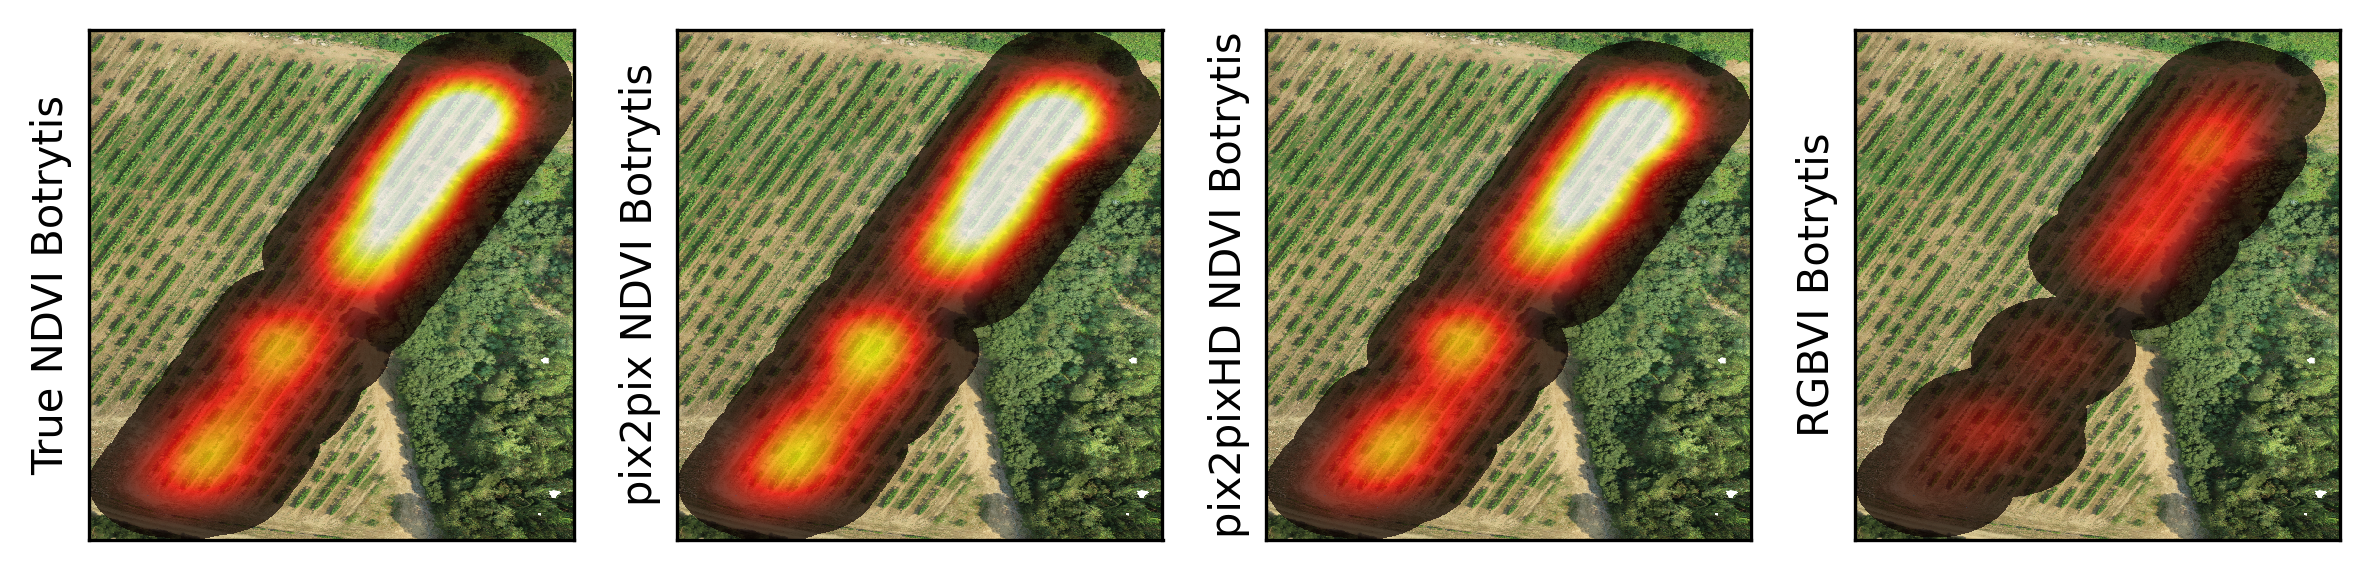

In [39]:

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

bounds = real_heatmap.rio.bounds()

rgb_down.plot.imshow(ax=ax[0],add_colorbar=False)
real_heatmap.plot(ax=ax[0], vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)

ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI Botrytis")
ax[0].set_xlim(bounds[0],bounds[2])
ax[0].set_ylim(bounds[1],bounds[3])

rgb_down.plot.imshow(ax=ax[1],add_colorbar=False)
fake_heatmap.plot(ax=ax[1],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI Botrytis")
ax[1].set_xlim(bounds[0],bounds[2])
ax[1].set_ylim(bounds[1],bounds[3])


rgb_down.plot.imshow(ax=ax[2],add_colorbar=False)
fakeHD_heatmap.plot(ax=ax[2],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI Botrytis")
ax[2].set_xlim(bounds[0],bounds[2])
ax[2].set_ylim(bounds[1],bounds[3])

rgb_down.plot.imshow(ax=ax[3],add_colorbar=False)
vi_heatmap.plot(ax=ax[3],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI Botrytis")
ax[3].set_xlim(bounds[0],bounds[2])
ax[3].set_ylim(bounds[1],bounds[3])

plt.tight_layout()
plt.savefig("figures/btg2022_bot_risk.png")
plt.show()

In [7]:
fake_heatmap = fake_heatmap.rio.reproject_match(real_heatmap)
fakeHD_heatmap = fakeHD_heatmap.rio.reproject_match(real_heatmap)
vi_heatmap = vi_heatmap.rio.reproject_match(real_heatmap)

In [8]:
# more alignment fixes for correlation checks.
# only extract heatmap values above 0

real_heatmap_mask = real_heatmap>0.0001
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

real_heatmap_mask = real_heatmap<6000
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

fake_heatmap_mask = fake_heatmap>0.0001
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fake_heatmap_mask = fake_heatmap<6000
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap>0.0001
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap<6000
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

#RGBVI
vi_heatmap_mask = vi_heatmap>0.0001
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

vi_heatmap_mask = vi_heatmap<6000
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

In [9]:
# FOR CORRELATION CHECKS:
#flatten the ndvi arrays
ndvi_p2phd_flat = fakeHD_heatmap.values.flatten()
ndvi_p2p_flat = fake_heatmap.values.flatten()
ndvi_test_flat = real_heatmap.values.flatten()
vi_flat = vi_heatmap.values.flatten()

In [10]:
# and perhaps some more R2 and rmse times...
from sklearn.metrics import r2_score, mean_squared_error
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
x= df["ndvi_p2p"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared p2p ground:", "{:.3f}".format(r2))
print("Mean Squared Error p2p ground:", "{:.3f}".format(mse))
print("Root Mean Squared Error p2p ground:", "{:.2f}".format(rmse))

R-squared p2p ground: 0.977
Mean Squared Error p2p ground: 1.095
Root Mean Squared Error p2p ground: 1.05


In [11]:
# and perhaps some more R2 and rmse times...

df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
x= df["ndvi_p2phd"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared p2pHD ground:", "{:.3f}".format(r2))
print("Mean Squared Error p2pHD ground:", "{:.3f}".format(mse))
print("Root Mean Squared Error p2pHD ground:", "{:.2f}".format(rmse))

R-squared p2pHD ground: 0.951
Mean Squared Error p2pHD ground: 2.066
Root Mean Squared Error p2pHD ground: 1.44


In [12]:
# and perhaps some more R2 and rmse times...

df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "rgbvi":vi_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
x= df["rgbvi"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared RGBVI ground:", "{:.3f}".format(r2))
print("Mean Squared Error RGBVI ground:", "{:.3f}".format(mse))
print("Root Mean Squared Error RGBVI ground:", "{:.2f}".format(rmse))

R-squared RGBVI ground: -10.365
Mean Squared Error RGBVI ground: 58.265
Root Mean Squared Error RGBVI ground: 7.63


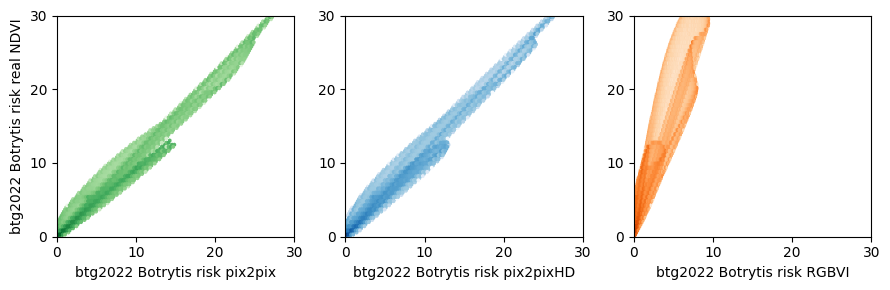

In [13]:
fig, ax = plt.subplots(figsize=(9,3), ncols =3)


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[0],x = "ndvi_p2p", y = "ndvi_true", gridsize=100,cmap = 'Greens', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)


ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[0].set_xticks([0, 10, 20, 30])
ax[0].set_yticks([0, 10, 20, 30])

ax[0].set_xlabel('btg2022 Botrytis risk pix2pix')
ax[0].set_ylabel('btg2022 Botrytis risk real NDVI')


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[1],x = "ndvi_p2phd", y = "ndvi_true", gridsize=100,cmap = 'Blues', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[1].set_xlim(0,30)
ax[1].set_ylim(0,30)
ax[1].set_xticks([0, 10, 20, 30])
ax[1].set_yticks([0, 10, 20, 30])

ax[1].set_xlabel('btg2022 Botrytis risk pix2pixHD')
ax[1].set_ylabel('')


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "rgbvi":vi_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[2],x = "rgbvi", y = "ndvi_true", gridsize=100,cmap = 'Oranges', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[2].set_xlim(0,30)
ax[2].set_ylim(0,30)
ax[2].set_xticks([0, 10, 20, 30])
ax[2].set_yticks([0, 10, 20, 30])

ax[2].set_xlabel('btg2022 Botrytis risk RGBVI')
ax[2].set_ylabel('')


plt.tight_layout()
plt.savefig("figures/btg_bot_hexbin_true_vs_p2p_p2phd.png", dpi =300)
plt.show()

# 3. BBR on Canyelles dataset

# 3.1. can2023 preprocessing

TODO: 
* Create the plants.geojson with the 2.5m x 3m grid
* Create plant_locations.geojson with just plant_id and coordinate
* extract all the correct values from the rasters to this plant.geojson
    * extract, mean, max, avg, min, etc.
* repeat extraction for NDVI, fakeNDVI, fakeNDVI-HD
* Run through `forest.predict()`
* link plant_id to location
* extract centroids
* Kernel density estimation of all three datasets.
* Compare

In [1]:
ndvi_test = rxr.open_rasterio("../data/canyelles/orthos/preprocessed/ndvi_test.tif")
ndvi_p2p = rxr.open_rasterio("../data/canyelles/orthos/preprocessed/ndvi_p2p.tif")
ndvi_p2phd= rxr.open_rasterio("../data/canyelles/orthos/preprocessed/ndvi_p2phd.tif")
chm= rxr.open_rasterio("../data/canyelles/orthos/preprocessed/chm.tif")
rgbvi= rxr.open_rasterio("../data/canyelles/orthos/preprocessed/rgbvi.tif")
dsm= rxr.open_rasterio("../data/canyelles/orthos/preprocessed/dsm.tif")
dem= rxr.open_rasterio("../data/canyelles/orthos/preprocessed/dem.tif")
rgb= rxr.open_rasterio("../data/canyelles/orthos/preprocessed/rgb.tif")

NameError: name 'rxr' is not defined

In [11]:
# Shadows/LAI implementation
shadows = ug.compute.calc_vineyard_shadows(rgb)

In [12]:
#select plants only
vines_mask = ((chm >= 0.5) & (chm <= 2))
vines_chm = chm.where( vines_mask)
vines_chm = vines_chm.rio.write_nodata(vines_chm.rio.nodata, encoded = True)

In [13]:
# only extract NDVI from thwere there are vine plants
vines_ndvi_test = ndvi_test.where(vines_mask)
vines_ndvi_test_mask = vines_ndvi_test<1
vines_ndvi_test = vines_ndvi_test.where(vines_ndvi_test_mask)
vines_ndvi_test = vines_ndvi_test.rio.write_nodata(vines_ndvi_test.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2p = ndvi_p2p.where(vines_mask)
vines_ndvi_p2p_mask = vines_ndvi_p2p<1
vines_ndvi_p2p = vines_ndvi_p2p.where(vines_ndvi_p2p_mask)
vines_ndvi_p2p = vines_ndvi_p2p.rio.write_nodata(vines_ndvi_p2p.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2phd = ndvi_p2phd.where(vines_mask)
vines_ndvi_p2phd_mask = vines_ndvi_p2phd<1
vines_ndvi_p2phd = vines_ndvi_p2phd.where(vines_ndvi_p2phd_mask)
vines_ndvi_p2phd= vines_ndvi_p2phd.rio.write_nodata(vines_ndvi_p2phd.rio.nodata, encoded = True)

# only extract NDVI from thwere there are vine plants
vines_ndvi_rgbvi = rgbvi.where(vines_mask)
vines_ndvi_rgbvi_mask = vines_ndvi_rgbvi<1
vines_ndvi_rgbvi = vines_ndvi_rgbvi.where(vines_ndvi_rgbvi_mask)
vines_ndvi_rgbvi= vines_ndvi_rgbvi.rio.write_nodata(vines_ndvi_rgbvi.rio.nodata, encoded = True)

## 3.2. extract the values 
* programatically create the 2.5x3 plants-grid: nah manually do it in qgis: this can be done later for uavgeo
* 
* extract all the correct values from the rasters to this plant.geojson
    * count_shadow,
    * min_CHM, max_CHM, mean_CHM, std_CHM, median_CHM, count_CHM
    * min_NDVI, max_NDVI, mean_NDVI, std_NDVI, median_NDVI, count_NDVI
    * min_DTM, max_DTM, mean_DTM, std_DTM, median_DTM
* repeat extraction for NDVI, fakeNDVI, fakeNDVI-HD

In [14]:
t = gpd.read_file("../data/bbr/can2023/plants.geojson")

In [15]:
# set dtm values to the same range as btg2021, as a sort of normalization step:
rmin = 202.03 #dem.min()
rmax = 213.79
tmin =63.30893
tmax = 87.72105
dem = ((dem-rmin)/(rmax-rmin)) * (tmax-tmin) + tmin

In [16]:
#extract values, as based from the BBR paper

ndvi_true_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_test,  stats = ["min", "max", "mean", "std", "median", "count"],  prefix = "NDVI_")
ndvi_fake_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2p, stats = ["min", "max", "mean", "std", "median", "count"],prefix= "NDVI_")
ndvi_fakehd_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2phd,stats = ["min", "max", "mean", "std", "median", "count"], prefix = "NDVI_")
rgbvi_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_rgbvi,stats = ["min", "max", "mean", "std", "median", "count"], prefix= "NDVI_")


chm_df = ug.compute.extract_features(gpd_df=t, xr=vines_chm,stats = ["min", "max", "mean", "std", "median", "count"], prefix= "CHM_")
dtm_df = ug.compute.extract_features(gpd_df=t, xr=dem, stats = ["min", "max", "mean", "std", "median"], prefix="DTM_")
shadows_df = ug.compute.extract_features(gpd_df=t, xr=shadows, stats=["count"], prefix="SHADOWS_")


In [17]:
#drop lowest 10 percent of shadows/LAI as it is essentially noise
lowest_10percent = shadows_df["SHADOWS_count"].nsmallest(int(len(shadows_df)/10))
shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0

C:\Users\judoj\AppData\Local\Temp\ipykernel_18792\4214284385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0


In [18]:
# join the DFs in to real, fake, fakeHD
real = pd.merge(left = ndvi_true_df,right= chm_df, on = "id") 
real = pd.merge(left=real, right = dtm_df, on = "id")
real = real.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)
real = pd.merge(left=real, right = shadows_df, on = "id")
real = real.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)

# join the DFs in to real, fake, fakeHD
fake = pd.merge(left = ndvi_fake_df,right= chm_df, on = "id") 
fake= pd.merge(left=fake, right = dtm_df, on = "id")
fake = fake.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)
fake = pd.merge(left=fake, right = shadows_df, on = "id")
fake = fake.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)


# join the DFs in to real, fake, fakeHD
fakeHD = pd.merge(left = ndvi_fakehd_df,right= chm_df, on = "id") 
fakeHD = pd.merge(left=fakeHD, right = dtm_df, on = "id")
fakeHD = fakeHD.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)
fakeHD = pd.merge(left=fakeHD, right = shadows_df, on = "id")
fakeHD = fakeHD.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)

vi = pd.merge(left = rgbvi_df,right= chm_df, on = "id") 
vi = pd.merge(left=vi, right = dtm_df, on = "id")
vi = vi.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)
vi = pd.merge(left=vi, right = shadows_df, on = "id")
vi = vi.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)

## 3.3. predict on the values, and generate KDE rasters

In [20]:
colname_remap = {
    'NDVI_min': "min_NDVI",
    'NDVI_max': "max_NDVI",
    'NDVI_mean': "mean_NDVI",
    'NDVI_count': "count_NDVI",
    'NDVI_std': "std_NDVI",
    'NDVI_median': "median_NDVI",
    'CHM_min': "min_CHM",
    'CHM_max': "max_CHM",
    'CHM_mean': "mean_CHM",
    'CHM_count': "count_CHM",
    'CHM_std': "std_CHM",
    'CHM_median': "median_CHM",
    'DTM_min': "min_DTM",
    'DTM_max': "max_DTM",
    'DTM_mean': "mean_DTM",
    'DTM_std': "std_DTM",
    'DTM_median': "median_DTM",
    'SHADOWS_count': "count_shadow"
}

In [21]:
real = real.rename(columns = colname_remap)
fake = fake.rename(columns = colname_remap)
fakeHD = fakeHD.rename(columns = colname_remap)
vi = vi.rename(columns= colname_remap)

In [ ]:
#mean normalize everything:
# DO NNOT RUN
#min-max normalize everything:
rf_real_n=(real-real.min())/(real.max()-real.min())
rf_fake_n=(fake-fake.min())/(fake.max()-fake.min())
rf_fakeHD_n=(fakeHD-fakeHD.min())/(fakeHD.max()-fake.min())
rf_vi_n = (vi-vi.min())/(vi.max()-vi.min())

In [22]:
rf_real_n = real
rf_fake_n = fake
rf_fakeHD_n = fakeHD
rf_vi_n = vi

In [23]:
#prep dataset to go into forest.predict()
#requires training_set from first code-box above.

rf_real_n = rf_real_n[training_set.columns].fillna(0)
rf_fake_n = rf_fake_n[training_set.columns].fillna(0)
rf_fakeHD_n = rf_fakeHD_n[training_set.columns].fillna(0)
rf_vi_n = rf_vi_n[training_set.columns].fillna(0)

In [24]:
real["status"] = forest.predict(rf_real_n)
fake["status"] = forest.predict(rf_fake_n)
fakeHD["status"] = forest.predict(rf_fakeHD_n)
vi["status"] = forest.predict(rf_vi_n)

In [25]:
# rejoin the geometries from the grid dataset
real_pred= t.merge(real, on = "id")[["geometry","id", "status"]]
fake_pred= t.merge(fake, on = "id",)[["geometry","id", "status"]]
fakeHD_pred = t.merge(fakeHD, on = "id",)[["geometry","id", "status"]]
vi_pred = t.merge(vi, on ="id")[["geometry","id", "status"]]

In [26]:
# export the predictions to file, ready for KDE mapping onto a raster.
real_pred = real_pred.set_geometry(real_pred.geometry.centroid)
real_pred.to_file("../data/bbr/can2023/real_pred_kde_input.geojson")
fake_pred = fake_pred.set_geometry(fake_pred.geometry.centroid)
fake_pred.to_file("../data/bbr/can2023/fake_pred_kde_input.geojson")
fakeHD_pred = fakeHD_pred.set_geometry(fakeHD_pred.geometry.centroid)
fakeHD_pred.to_file("../data/bbr/can2023/fakeHD_pred_kde_input.geojson")

vi_pred = vi_pred.set_geometry(vi_pred.geometry.centroid)
vi_pred.to_file("../data/bbr/can2023/vi_pred_kde_input.geojson")


* run notebook 8b to create the heatmaps.tif
* I made a different environment to make spatial_kde install with python 3.10 
* now stored under: "../data/bbr/btg2022/fake_bot_heatmap.tif"
* then continue below

## 3.4 Evaluate KDE maps


In [23]:
# loading KDE maps:

real_heatmap = rxr.open_rasterio("../data/bbr/can2023/real_bot_heatmap.tif")
fake_heatmap = rxr.open_rasterio("../data/bbr/can2023/fake_bot_heatmap.tif")
fakeHD_heatmap = rxr.open_rasterio("../data/bbr/can2023/fakeHD_bot_heatmap.tif")
vi_heatmap = rxr.open_rasterio("../data/bbr/can2023/vi_bot_heatmap.tif")
rgb = rxr.open_rasterio("../data/canyelles/orthos/rgb_230609.tif")

In [24]:
rgb = rgb.rio.reproject("EPSG:32631")
#rgb = rgb.rio.reproject_match(real_heatmap)

In [25]:
# only extract heatmap values above 0

real_heatmap_mask = real_heatmap>0.01
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

fake_heatmap_mask = fake_heatmap>0.01
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap>0.01
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)
#RGBVI
vi_heatmap_mask = vi_heatmap>0.0001
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

vi_heatmap_mask = vi_heatmap<6000
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

In [26]:
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
    rgb.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


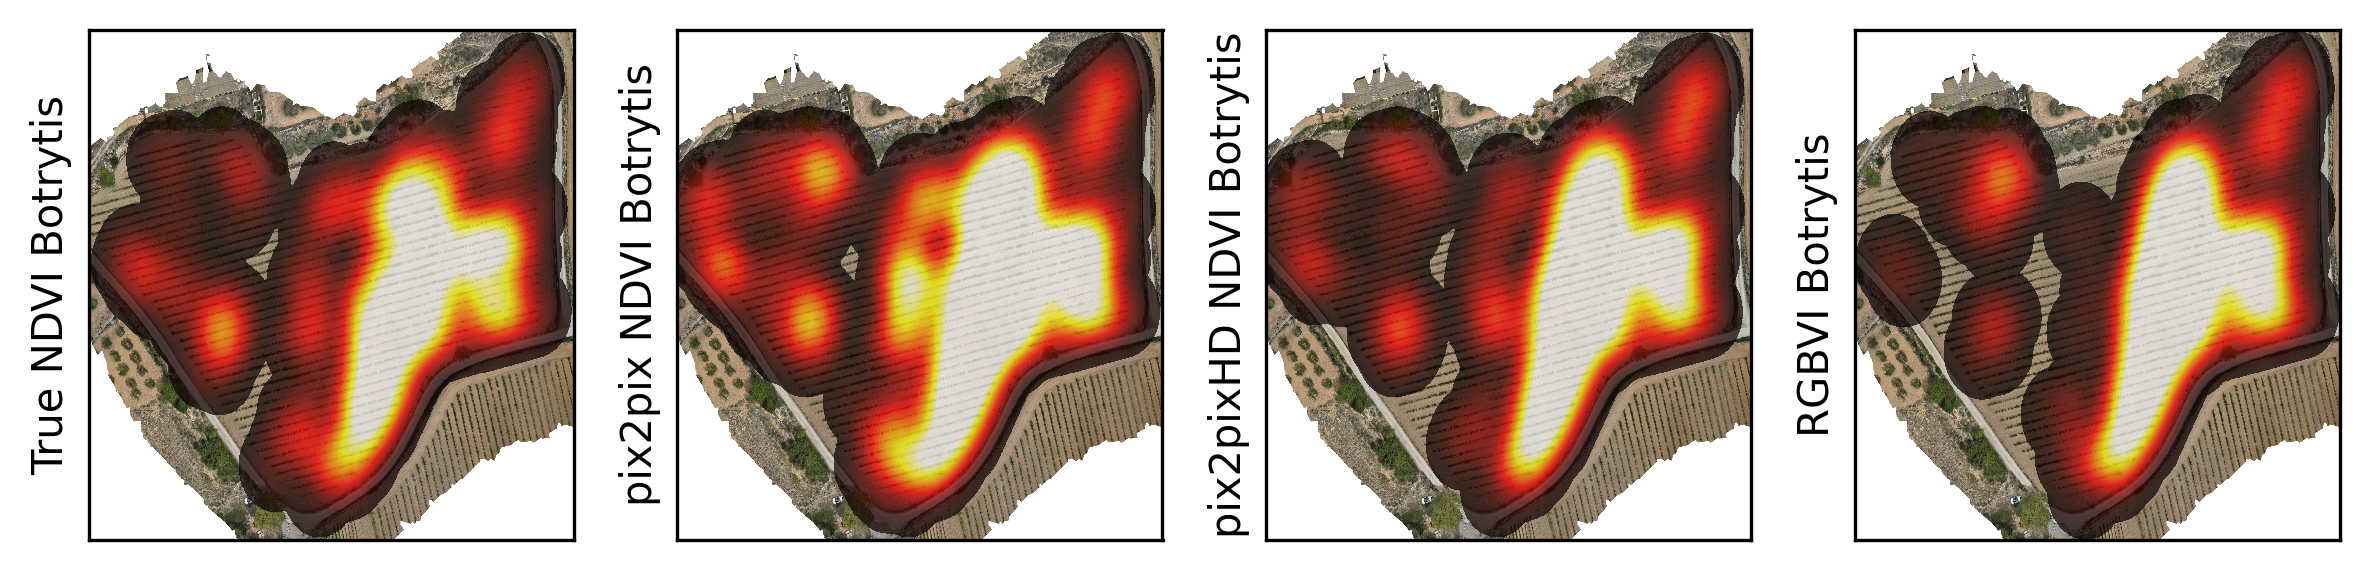

In [27]:

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

bounds = real_heatmap.rio.bounds()

rgb_down.plot.imshow(ax=ax[0],add_colorbar=False)
real_heatmap.plot(ax=ax[0], vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)

ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI Botrytis")
ax[0].set_xlim(bounds[0],bounds[2])
ax[0].set_ylim(bounds[1],bounds[3])

rgb_down.plot.imshow(ax=ax[1],add_colorbar=False)
fake_heatmap.plot(ax=ax[1],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI Botrytis")
ax[1].set_xlim(bounds[0],bounds[2])
ax[1].set_ylim(bounds[1],bounds[3])


rgb_down.plot.imshow(ax=ax[2],add_colorbar=False)
fakeHD_heatmap.plot(ax=ax[2],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI Botrytis")
ax[2].set_xlim(bounds[0],bounds[2])
ax[2].set_ylim(bounds[1],bounds[3])

rgb_down.plot.imshow(ax=ax[3],add_colorbar=False)
vi_heatmap.plot(ax=ax[3],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI Botrytis")
ax[3].set_xlim(bounds[0],bounds[2])
ax[3].set_ylim(bounds[1],bounds[3])

plt.tight_layout()
plt.savefig("figures/can2023_bot_risk.png")
plt.show()

In [40]:
fake_heatmap = fake_heatmap.rio.reproject_match(real_heatmap)
fakeHD_heatmap = fakeHD_heatmap.rio.reproject_match(real_heatmap)
vi_heatmap = vi_heatmap.rio.reproject_match(real_heatmap)

In [41]:
fake_heatmap_mask = fake_heatmap>0.01
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fake_heatmap_mask = fake_heatmap<6000
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap>0.01
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap<6000
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)
#RGBVI
vi_heatmap_mask = vi_heatmap>0.0001
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

vi_heatmap_mask = vi_heatmap<6000
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

In [42]:
# FOR CORRELATION CHECKS:
#flatten the ndvi arrays
ndvi_p2phd_flat = fakeHD_heatmap.values.flatten()
ndvi_p2p_flat = fake_heatmap.values.flatten()
ndvi_test_flat = real_heatmap.values.flatten()
vi_flat=  vi_heatmap.values.flatten()

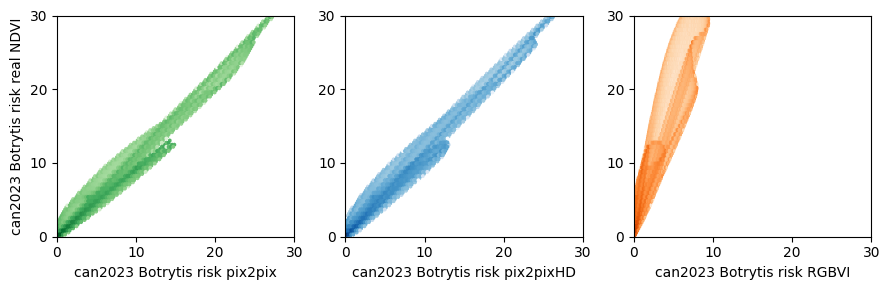

In [43]:
fig, ax = plt.subplots(figsize=(9,3), ncols =3)


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[0],x = "ndvi_p2p", y = "ndvi_true", gridsize=100,cmap = 'Greens', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)


ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[0].set_xticks([0, 10, 20, 30])
ax[0].set_yticks([0, 10, 20, 30])

ax[0].set_xlabel('can2023 Botrytis risk pix2pix')
ax[0].set_ylabel('can2023 Botrytis risk real NDVI')


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[1],x = "ndvi_p2phd", y = "ndvi_true", gridsize=100,cmap = 'Blues', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[1].set_xlim(0,30)
ax[1].set_ylim(0,30)
ax[1].set_xticks([0, 10, 20, 30])
ax[1].set_yticks([0, 10, 20, 30])

ax[1].set_xlabel('can2023 Botrytis risk pix2pixHD')
ax[1].set_ylabel('')


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "rgbvi":vi_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[2],x = "rgbvi", y = "ndvi_true", gridsize=100,cmap = 'Oranges', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[2].set_xlim(0,30)
ax[2].set_ylim(0,30)
ax[2].set_xticks([0, 10, 20, 30])
ax[2].set_yticks([0, 10, 20, 30])

ax[2].set_xlabel('can2023 Botrytis risk RGBVI')
ax[2].set_ylabel('')


plt.tight_layout()
plt.savefig("figures/can_bot_hexbin_true_vs_p2p_p2phd.png", dpi =300)
plt.show()

In [32]:
# and perhaps some more R2 and rmse times...
from sklearn.metrics import r2_score, mean_squared_error
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df = df.dropna(axis=0)

x= df["ndvi_p2p"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared p2p BOT:", "{:.3f}".format(r2))
print("Mean Squared Error p2p BOT:", "{:.3f}".format(mse))
print("Root Mean Squared Error p2p BOT:", "{:.2f}".format(rmse))

R-squared p2p BOT: 0.807
Mean Squared Error p2p BOT: 17.529
Root Mean Squared Error p2p BOT: 4.19


In [33]:
# and perhaps some more R2 and rmse times...

df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df = df.dropna(axis=0)

x= df["ndvi_p2phd"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared p2pHD BOT:", "{:.3f}".format(r2))
print("Mean Squared Error p2pHD BOT:", "{:.3f}".format(mse))
print("Root Mean Squared Error p2pHD BOT:", "{:.2f}".format(rmse))

R-squared p2pHD BOT: 0.935
Mean Squared Error p2pHD BOT: 5.309
Root Mean Squared Error p2pHD BOT: 2.30


In [34]:
# and perhaps some more R2 and rmse times...

df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "vi":vi_flat})
df = df.dropna(axis=0)

x= df["vi"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared vi BOT:", "{:.3f}".format(r2))
print("Mean Squared Error vi BOT:", "{:.3f}".format(mse))
print("Root Mean Squared Error vi BOT:", "{:.2f}".format(rmse))

R-squared vi BOT: 0.901
Mean Squared Error vi BOT: 8.996
Root Mean Squared Error vi BOT: 3.00


# BTG2021-test BBR 

In [4]:
ndvi_test = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_test.tif", mode="w")
ndvi_p2p = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_p2p.tif", mode="w")
ndvi_p2phd= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_p2phd.tif", mode="w")
chm= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/chm.tif", mode="w")
rgbvi= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/rgbvi.tif", mode="w")
dsm= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/dsm.tif", mode="w")
dem= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/dem.tif", mode="w")
rgb= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/rgb.tif", mode="w")

In [5]:

#and the mask
roi = gpd.read_file("../data/bbr/btg2021_test/roi.geojson")

In [6]:
#clip all to the same extent
ndvi_test = ndvi_test.rio.clip(roi.geometry)
ndvi_p2phd = ndvi_p2phd.rio.clip(roi.geometry)
ndvi_p2p = ndvi_p2p.rio.clip(roi.geometry)
chm = chm.rio.clip(roi.geometry)
rgb = rgb.rio.clip(roi.geometry)

dem = dem.rio.clip(roi.geometry)
dsm = dsm.rio.clip(roi.geometry)

In [7]:
# Shadows/LAI implementation
shadows = ug.compute.calc_vineyard_shadows(rgb)

In [8]:
#select plants only
vines_mask = ((chm >= 0.5) & (chm <= 2))
vines_chm = chm.where( vines_mask)
vines_chm = vines_chm.rio.write_nodata(vines_chm.rio.nodata, encoded = True)

In [9]:
# only extract NDVI from thwere there are vine plants
vines_ndvi_test = ndvi_test.where(vines_mask)
vines_ndvi_test_mask = vines_ndvi_test<1
vines_ndvi_test = vines_ndvi_test.where(vines_ndvi_test_mask)
vines_ndvi_test = vines_ndvi_test.rio.write_nodata(vines_ndvi_test.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2p = ndvi_p2p.where(vines_mask)
vines_ndvi_p2p_mask = vines_ndvi_p2p<1
vines_ndvi_p2p = vines_ndvi_p2p.where(vines_ndvi_p2p_mask)
vines_ndvi_p2p = vines_ndvi_p2p.rio.write_nodata(vines_ndvi_p2p.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2phd = ndvi_p2phd.where(vines_mask)
vines_ndvi_p2phd_mask = vines_ndvi_p2phd<1
vines_ndvi_p2phd = vines_ndvi_p2phd.where(vines_ndvi_p2phd_mask)
vines_ndvi_p2phd= vines_ndvi_p2phd.rio.write_nodata(vines_ndvi_p2phd.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_rgbvi = rgbvi.where(vines_mask)
vines_ndvi_rgbvi_mask = vines_ndvi_rgbvi<1
vines_ndvi_rgbvi = vines_ndvi_rgbvi.where(vines_ndvi_rgbvi_mask)
vines_ndvi_rgbvi= vines_ndvi_rgbvi.rio.write_nodata(vines_ndvi_rgbvi.rio.nodata, encoded = True)

## 3.2. extract the values 
* programatically create the 2.5x3 plants-grid: nah manually do it in qgis: this can be done later for uavgeo
* 
* extract all the correct values from the rasters to this plant.geojson
    * count_shadow,
    * min_CHM, max_CHM, mean_CHM, std_CHM, median_CHM, count_CHM
    * min_NDVI, max_NDVI, mean_NDVI, std_NDVI, median_NDVI, count_NDVI
    * min_DTM, max_DTM, mean_DTM, std_DTM, median_DTM
* repeat extraction for NDVI, fakeNDVI, fakeNDVI-HD

In [10]:
t = gpd.read_file("../data/bbr/btg2021_test/plants.geojson")

In [13]:
#extract values, as based from the BBR paper

ndvi_true_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_test,  stats = ["min", "max", "mean", "std", "median", "count"],  prefix = "NDVI_")
ndvi_fake_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2p, stats = ["min", "max", "mean", "std", "median", "count"],prefix= "NDVI_")
ndvi_fakehd_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2phd,stats = ["min", "max", "mean", "std", "median", "count"], prefix = "NDVI_")
rgbvi_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_rgbvi,stats = ["min", "max", "mean", "std", "median", "count"], prefix= "NDVI_")


chm_df = ug.compute.extract_features(gpd_df=t, xr=vines_chm,stats = ["min", "max", "mean", "std", "median", "count"], prefix= "CHM_")
dtm_df = ug.compute.extract_features(gpd_df=t, xr=dem, stats = ["min", "max", "mean", "std", "median"], prefix="DTM_")
shadows_df = ug.compute.extract_features(gpd_df=t, xr=shadows, stats=["count"], prefix="SHADOWS_")


In [15]:
#drop lowest 10 percent of shadows/LAI as it is essentially noise
lowest_10percent = shadows_df["SHADOWS_count"].nsmallest(int(len(shadows_df)/10))
shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0

C:\Users\judoj\AppData\Local\Temp\ipykernel_15404\4214284385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0


In [16]:
# join the DFs in to real, fake, fakeHD
real = pd.merge(left = ndvi_true_df,right= chm_df, on = "plantID") 

real = pd.merge(left=real, right = dtm_df, on = "plantID")
real = real.drop(["fid_x", "fid_2","fid_2_x",'intersects_x', 'box_id_x'], axis =1)
real = pd.merge(left=real, right = shadows_df, on = "plantID")
#real = real.drop(["fid_x", "fid_2", "fid_2_x"], axis =1)

# join the DFs in to real, fake, fakeHD
fake = pd.merge(left = ndvi_fake_df,right= chm_df, on = "plantID")

fake= pd.merge(left=fake, right = dtm_df, on = "plantID")
fake = fake.drop(["fid_x", "fid_2","fid_2_x",'intersects_x', 'box_id_x'], axis =1)

fake = pd.merge(left=fake, right = shadows_df, on = "plantID")

# join the DFs in to real, fake, fakeHD
fakeHD = pd.merge(left = ndvi_fakehd_df,right= chm_df, on = "plantID") 

fakeHD = pd.merge(left=fakeHD, right = dtm_df, on = "plantID")
fakeHD = fakeHD.drop(["fid_x", "fid_2","fid_2_x",'intersects_x', 'box_id_x'], axis =1)

fakeHD = pd.merge(left=fakeHD, right = shadows_df, on = "plantID")


vi = pd.merge(left = rgbvi_df,right= chm_df, on = "plantID") 

vi = pd.merge(left=vi, right = dtm_df, on = "plantID")
vi = vi.drop(["fid_x", "fid_2","fid_2_x",'intersects_x', 'box_id_x'], axis =1)

vi = pd.merge(left=vi, right = shadows_df, on = "plantID")


## 2.3. predict on the values, and generate KDE rasters

In [17]:
colname_remap = {
    'NDVI_min': "min_NDVI",
    'NDVI_max': "max_NDVI",
    'NDVI_mean': "mean_NDVI",
    'NDVI_count': "count_NDVI",
    'NDVI_std': "std_NDVI",
    'NDVI_median': "median_NDVI",
    'CHM_min': "min_CHM",
    'CHM_max': "max_CHM",
    'CHM_mean': "mean_CHM",
    'CHM_count': "count_CHM",
    'CHM_std': "std_CHM",
    'CHM_median': "median_CHM",
    'DTM_min': "min_DTM",
    'DTM_max': "max_DTM",
    'DTM_mean': "mean_DTM",
    'DTM_std': "std_DTM",
    'DTM_median': "median_DTM",
    'SHADOWS_count': "count_shadow"
}

In [18]:
real = real.rename(columns = colname_remap)
fake = fake.rename(columns = colname_remap)
fakeHD = fakeHD.rename(columns = colname_remap)
vi = vi.rename(columns = colname_remap)

In [21]:
#if top one is still ran, this also overwrites it agian
rf_real_n = real
rf_fake_n = fake
rf_fakeHD_n = fakeHD
rf_vi_n = vi

In [22]:
#prep dataset to go into forest.predict()
#requires training_set from first code-box above.

rf_real_n = rf_real_n[training_set.columns].fillna(0)
rf_fake_n = rf_fake_n[training_set.columns].fillna(0)
rf_fakeHD_n = rf_fakeHD_n[training_set.columns].fillna(0)
rf_vi_n  = rf_vi_n[training_set.columns].fillna(0)

In [23]:
real["status"] = forest.predict(rf_real_n)
fake["status"] = forest.predict(rf_fake_n)
fakeHD["status"] = forest.predict(rf_fakeHD_n)
vi["status"] = forest.predict(rf_vi_n)

In [24]:
t= t.drop(["fid_2"], axis=1)

In [25]:
# rejoin the geometries from the grid dataset
real_pred= t.merge(real, on = "plantID")[["geometry","plantID", "status"]]
fake_pred= t.merge(fake, on = "plantID",)[["geometry","plantID", "status"]]
fakeHD_pred = t.merge(fakeHD, on = "plantID",)[["geometry","plantID", "status"]]
vi_pred = t.merge(vi, on ="plantID",)[["geometry","plantID", "status"]]

In [26]:
# export the predictions to file, ready for KDE mapping onto a raster.
real_pred = real_pred.set_geometry(real_pred.geometry.centroid)
real_pred.to_file("../data/bbr/btg2021_test/real_pred_kde_input.geojson")
fake_pred = fake_pred.set_geometry(fake_pred.geometry.centroid)
fake_pred.to_file("../data/bbr/btg2021_test/fake_pred_kde_input.geojson")
fakeHD_pred = fakeHD_pred.set_geometry(fakeHD_pred.geometry.centroid)
fakeHD_pred.to_file("../data/bbr/btg2021_test/fakeHD_pred_kde_input.geojson")
vi_pred = vi_pred.set_geometry(vi_pred.geometry.centroid)
vi_pred.to_file("../data/bbr/btg2021_test/vi_pred_kde_input.geojson")

* run notebook 8b to create the heatmaps.tif
* I made a different environment to make spatial_kde install with python 3.10 
* now stored under: "../data/bbr/btg2022/fake_bot_heatmap.tif"
* then continue below

## 2.4 Evaluate KDE maps

In [6]:
# loading KDE maps:

real_heatmap = rxr.open_rasterio("../data/bbr/btg2021_test/real_bot_heatmap.tif")
fake_heatmap = rxr.open_rasterio("../data/bbr/btg2021_test/fake_bot_heatmap.tif")
fakeHD_heatmap = rxr.open_rasterio("../data/bbr/btg2021_test/fakeHD_bot_heatmap.tif")
vi_heatmap = rxr.open_rasterio("../data/bbr/btg2021_test/vi_bot_heatmap.tif")

ortho= rxr.open_rasterio("../data/orthos/ms_2021.tif")

In [8]:

ortho= rxr.open_rasterio("../data/orthos/ms_2021.tif")
# gotta scale the input rastser to have nice RGB values:
# exploreation in QGIS seems like the following RGB max-values:
r = 7500
g = 7500
b = 6000

r_new = ug.compute.scale_band_to_min_max(ortho.sel(band=3), min = 0, max = r)
g_new = ug.compute.scale_band_to_min_max(ortho.sel(band=2), min = 0, max = g)
b_new = ug.compute.scale_band_to_min_max(ortho.sel(band=1), min = 0, max = b)
rgb = xr.combine_nested([r_new, g_new, b_new],concat_dim = "band")
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
    rgb.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


In [9]:
# only extract heatmap values above 0

real_heatmap_mask = real_heatmap>0.0001
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

real_heatmap_mask = real_heatmap<6000
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

#pix2pix
fake_heatmap_mask = fake_heatmap>0.0001
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fake_heatmap_mask = fake_heatmap<6000
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

#pix2pixHD
fakeHD_heatmap_mask = fakeHD_heatmap>0.0001
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap<6000
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

#RGBVI
vi_heatmap_mask = vi_heatmap>0.0001
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

vi_heatmap_mask = vi_heatmap<6000
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)


In [10]:
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
    rgb.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


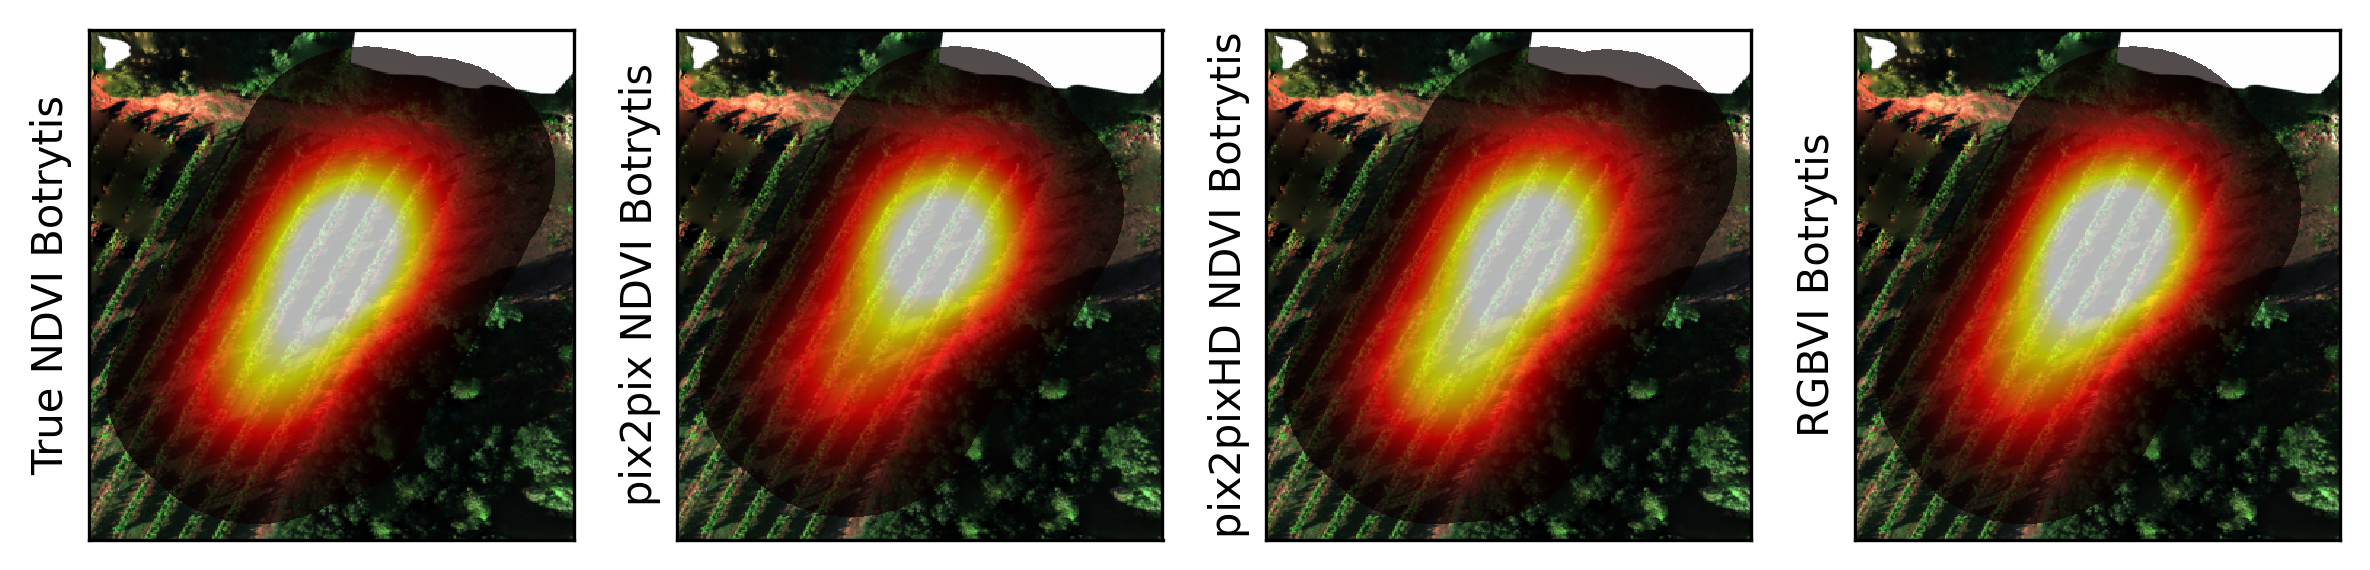

In [11]:

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

bounds = real_heatmap.rio.bounds()
off =2
rgb_down.plot.imshow(ax=ax[0],add_colorbar=False)
real_heatmap.plot(ax=ax[0], vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)

ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI Botrytis")
ax[0].set_xlim(bounds[0]-off,bounds[2]+off)
ax[0].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[1],add_colorbar=False)
fake_heatmap.plot(ax=ax[1],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI Botrytis")
ax[1].set_xlim(bounds[0]-off,bounds[2]+off)
ax[1].set_ylim(bounds[1]-off,bounds[3]+off)


rgb_down.plot.imshow(ax=ax[2],add_colorbar=False)
fakeHD_heatmap.plot(ax=ax[2],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI Botrytis")
ax[2].set_xlim(bounds[0]-off,bounds[2]+off)
ax[2].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[3],add_colorbar=False)
vi_heatmap.plot(ax=ax[3],vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI Botrytis")
ax[3].set_xlim(bounds[0]-off,bounds[2]+off)
ax[3].set_ylim(bounds[1]-off,bounds[3]+off)

plt.tight_layout()
plt.savefig("figures/btg2021_bot_risk.png")
plt.show()

In [12]:
fake_heatmap = fake_heatmap.rio.reproject_match(real_heatmap)
fakeHD_heatmap = fakeHD_heatmap.rio.reproject_match(real_heatmap)
vi_heatmap = vi_heatmap.rio.reproject_match(real_heatmap)

In [13]:
fake_heatmap_mask = fake_heatmap>0.01
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fake_heatmap_mask = fake_heatmap<6000
fake_heatmap = fake_heatmap.where(fake_heatmap_mask)
fake_heatmap = fake_heatmap.rio.write_nodata(fake_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap>0.01
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)

fakeHD_heatmap_mask = fakeHD_heatmap<6000
fakeHD_heatmap = fakeHD_heatmap.where(fakeHD_heatmap_mask)
fakeHD_heatmap = fakeHD_heatmap.rio.write_nodata(fakeHD_heatmap.rio.nodata, encoded = True)
#RGBVI
vi_heatmap_mask = vi_heatmap>0.0001
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

vi_heatmap_mask = vi_heatmap<6000
vi_heatmap = vi_heatmap.where(vi_heatmap_mask)
vi_heatmap = vi_heatmap.rio.write_nodata(vi_heatmap.rio.nodata, encoded = True)

In [14]:
# FOR CORRELATION CHECKS:
#flatten the ndvi arrays
ndvi_p2phd_flat = fakeHD_heatmap.values.flatten()
ndvi_p2p_flat = fake_heatmap.values.flatten()
ndvi_test_flat = real_heatmap.values.flatten()
vi_flat=  vi_heatmap.values.flatten()

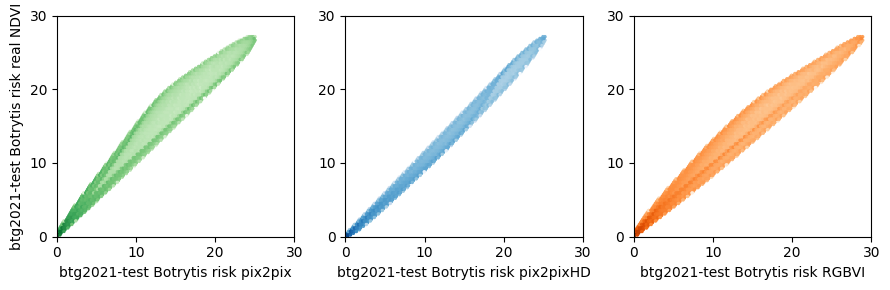

In [15]:
fig, ax = plt.subplots(figsize=(9,3), ncols =3)


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[0],x = "ndvi_p2p", y = "ndvi_true", gridsize=100,cmap = 'Greens', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)


ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[0].set_xticks([0, 10, 20, 30])
ax[0].set_yticks([0, 10, 20, 30])

ax[0].set_xlabel('btg2021-test Botrytis risk pix2pix')
ax[0].set_ylabel('btg2021-test Botrytis risk real NDVI')


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[1],x = "ndvi_p2phd", y = "ndvi_true", gridsize=100,cmap = 'Blues', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[1].set_xlim(0,30)
ax[1].set_ylim(0,30)
ax[1].set_xticks([0, 10, 20, 30])
ax[1].set_yticks([0, 10, 20, 30])

ax[1].set_xlabel('btg2021-test Botrytis risk pix2pixHD')
ax[1].set_ylabel('')


df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "rgbvi":vi_flat})
df = df.replace([np.inf, -np.inf], 0).dropna(axis=0)
#df = df.dropna(axis=0)
df = df.fillna(0)
#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[2],x = "rgbvi", y = "ndvi_true", gridsize=100,cmap = 'Oranges', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[2].set_xlim(0,30)
ax[2].set_ylim(0,30)
ax[2].set_xticks([0, 10, 20, 30])
ax[2].set_yticks([0, 10, 20, 30])

ax[2].set_xlabel('btg2021-test Botrytis risk RGBVI')
ax[2].set_ylabel('')


plt.tight_layout()
plt.savefig("figures/btg2021_bot_hexbin_true_vs_p2p_p2phd.png", dpi =300)
plt.show()

In [16]:
# and perhaps some more R2 and rmse times...
from sklearn.metrics import r2_score, mean_squared_error
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df = df.dropna(axis=0)

x= df["ndvi_p2p"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared p2p BOT:", "{:.3f}".format(r2))
print("Mean Squared Error p2p BOT:", "{:.3f}".format(mse))
print("Root Mean Squared Error p2p BOT:", "{:.2f}".format(rmse))

R-squared p2p BOT: 0.907
Mean Squared Error p2p BOT: 3.837
Root Mean Squared Error p2p BOT: 1.96


In [17]:
# and perhaps some more R2 and rmse times...

df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df = df.dropna(axis=0)

x= df["ndvi_p2phd"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared p2pHD BOT:", "{:.3f}".format(r2))
print("Mean Squared Error p2pHD BOT:", "{:.3f}".format(mse))
print("Root Mean Squared Error p2pHD BOT:", "{:.2f}".format(rmse))

R-squared p2pHD BOT: 0.988
Mean Squared Error p2pHD BOT: 0.536
Root Mean Squared Error p2pHD BOT: 0.73


In [18]:
# and perhaps some more R2 and rmse times...

df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "vi":vi_flat})
df = df.dropna(axis=0)

x= df["vi"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared vi BOT:", "{:.3f}".format(r2))
print("Mean Squared Error vi BOT:", "{:.3f}".format(mse))
print("Root Mean Squared Error vi BOT:", "{:.2f}".format(rmse))

R-squared vi BOT: 0.979
Mean Squared Error vi BOT: 1.162
Root Mean Squared Error vi BOT: 1.08


In [ ]:
# some rubbish things:

In [ ]:
# create a grid of points:
import geopandas as gpd
import numpy as np

# Define the bounding box for the grid
xmin, ymin, xmax, ymax = mask.bounds.values[0]
# Define the distance between points
distance = 0.1

# Create arrays of x and y coordinates based on the specified distance
x_values = np.arange(xmin, xmax + distance, distance)
y_values = np.arange(ymin, ymax + distance, distance)

# Use numpy.meshgrid to create a grid of coordinates
xx, yy = np.meshgrid(x_values, y_values)

# Reshape the coordinate arrays and stack them to get a list of (x, y) pairs
grid_points = np.column_stack((xx.ravel(), yy.ravel()))

# Create a GeoDataFrame with the grid points
geometry = gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1])
grid_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:32631')

In [ ]:
#sample the vines_mask to check whether point is in/near a plant
# I love xarray: so fast! (3 million points or so)
da_x = xr.DataArray(grid_gdf.geometry.x.values, dims=['z'])
da_y = xr.DataArray(grid_gdf.geometry.y.values, dims=['z'])
results = vines_mask.sel(x=da_x, y=da_y, method='nearest')
grid_gdf["is_plant"]= results.values[0]

In [ ]:
grid_gdf = grid_gdf[grid_gdf["is_plant"]].copy()

In [ ]:
import pandas as pd
import geopandas as gpd
import shapely

from sklearn.cluster import AgglomerativeClustering

def cluster_shapes_by_distance(geodf, distance, check_crs=False):
    """
    Make groups for all shapes within a defined distance. For a shape to be 
    excluded from a group, it must be greater than the defined distance
    from *all* shapes in the group.
    Distances are calculated using shape centroids.

    Parameters
    ----------
    geodf : data.frame
        A geopandas data.frame of polygons. Should be a projected CRS where the
        unit is in meters. 
    distance : float
        Maximum distance between elements. In meters.
    check_crs : bool
        Confirm that the CRS of the geopandas dataframe is projected. This 
        function should not be run with lat/lon coordinates. 

    Returns
    -------
    np.array
        Array of numeric labels assigned to each row in geodf.

    """
    if check_crs:
        assert geodf.crs.is_projected, 'geodf should be a projected crs with meters as the unit'
        
    centers = [p.centroid for p in geodf.geometry]
    centers_xy = [[c.x, c.y] for c in centers]
    
    cluster = AgglomerativeClustering(n_clusters=None, 
                                      linkage='single',
                                      affinity='euclidean',
                                      distance_threshold=distance)
    cluster.fit(centers_xy)
    
    return cluster.labels_


In [ ]:
grid_gdf['group'] = cluster_shapes_by_distance(grid_gdf, distance=.5) # 20m

In [ ]:
grid_gdf.geometry.buffer(distance=0.3)